<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-data" data-toc-modified-id="Get-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get data</a></span><ul class="toc-item"><li><span><a href="#All-data" data-toc-modified-id="All-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>All data</a></span></li><li><span><a href="#Subset" data-toc-modified-id="Subset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Subset</a></span></li></ul></li><li><span><a href="#Transform" data-toc-modified-id="Transform-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Transform</a></span><ul class="toc-item"><li><span><a href="#Showing-images-and-bboxes" data-toc-modified-id="Showing-images-and-bboxes-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Showing images and bboxes</a></span><ul class="toc-item"><li><span><a href="#Grabbing-one-im-and-bbox-for-testing" data-toc-modified-id="Grabbing-one-im-and-bbox-for-testing-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Grabbing one im and bbox for testing</a></span></li><li><span><a href="#show_im,-draw_outline,-draw_rect,-draw_text" data-toc-modified-id="show_im,-draw_outline,-draw_rect,-draw_text-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span><code>show_im</code>, <code>draw_outline</code>, <code>draw_rect</code>, <code>draw_text</code></a></span></li><li><span><a href="#BBox-and-ImageBBox-classes-with-show()-methods" data-toc-modified-id="BBox-and-ImageBBox-classes-with-show()-methods-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span><code>BBox</code> and <code>ImageBBox</code> classes with <code>show()</code> methods</a></span></li></ul></li></ul></li><li><span><a href="#Old-DataBlock-method" data-toc-modified-id="Old-DataBlock-method-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Old DataBlock method</a></span></li></ul></div>

# Get data

## All data

In [ ]:
from fastai.vision.all import *
from fastcore.test import *
import pandas as pd


### Unzip data ###
path = Path('/home/rory/data/coco2017')
path_items = path.ls()
from zipfile import ZipFile
def unzip(*paths,dest):
    """Unzips files located at posixpaths to dest. Deps: zipfile, pathlib."""
    for path in paths:
        if path.suffix == '.zip':
            print(f"Unzipping: {path} ---> {dest}.")
            with ZipFile(path, 'r') as archive:
                archive.extractall(dest)
    new_items = set(dest.ls()) - set(paths)
    print("Finished. New items in dest:",*new_items,sep='\n')
# unzip(*path_items, dest=path)


### Get ims and annos ###
ims_train, annos_train = get_annotations(path/'annotations/instances_train2017.json')
ims_valid, annos_valid = get_annotations(path/'annotations/instances_val2017.json')
ims_train = list(map(lambda x: path/'train2017'/x,ims_train))
ims_valid = list(map(lambda x: path/'val2017'/x,ims_valid))
ims    = ims_train + ims_valid
annos  = annos_train + annos_valid
bboxes = [i[0] for i in annos]
lbls   = [i[1] for i in annos]


### Process annos ###
def transpose(l): return list(zip(*l))
def bbox_area(anno_t): # takes a transposed anno
    b = anno_t[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos = [sort_annos(a) for a in annos]
largest_anno = [i[0] for i in sorted_annos]
largest_bbox = [i[0] for i in largest_anno]
largest_lbl  = [i[1] for i in largest_anno]
is_valid     = [False]*len(ims_train) + [True]*len(ims_valid)

### Store outputs in dfd, df ###
dfd_all = {
    "im":ims,
    "annos":annos,
    "bboxes":bboxes,
    "lbls":lbls,
    "sorted_annos":sorted_annos,
    "anno":largest_anno,
    "bbox":largest_bbox,
    "lbl":largest_lbl,
    "is_valid":is_valid}
df_all = pd.DataFrame(dfd_all)

## Subset

In [ ]:
### Get subset
sample_frac = .1

df = pd.DataFrame(df_all[['im', 'bbox', 'is_valid']]
                     .sample(frac=sample_frac)
                     .reset_index()
                     .drop(columns='index')        # Note that drop creates a copy, so using
                    ).copy()                       ## .copy() is reundant (but good practice).
dfd = df.to_dict()
df.head(3)

,im,bbox,is_valid
0,/home/rory/data/coco2017/train2017/000000298981.jpg,"[0.0, 18.4, 480.0, 467.72999999999996]",False
1,/home/rory/data/coco2017/train2017/000000209480.jpg,"[129.33, 21.97, 523.52, 436.05999999999995]",False
2,/home/rory/data/coco2017/train2017/000000558412.jpg,"[172.71, 140.0, 331.83000000000004, 367.87]",False


# Transform

## Showing images and bboxes

### Grabbing one im and bbox for testing

In [ ]:
paths = L(dfd['im'][i] for i in range(len(dfd['im']))); paths[0]
path2bbox = {dfd['im'][i]:dfd['bbox'][i] for i in range(len(dfd['im']))}

imp = paths[0]
im = PILImage.create(imp)
bbox = path2bbox[imp]
bbox = TensorPoint(bbox[:2]), TensorPoint(bbox[-2:])
im.shape, bbox

((640, 480),
 (TensorPoint([ 0.0000, 18.4000]), TensorPoint([480.0000, 467.7300])))

### `show_im`, `draw_outline`, `draw_rect`, `draw_text`

https://www.youtube.com/watch?v=Z0ssNAbe81M @ 1:18:00

In [ ]:
from matplotlib import patches, patheffects

def show_im(im, figsize=None, ax=None, tickmarks=False):
    if not ax: fig,ax = plt.subplots(figsize=figsize) # we don't care about fig
    ax.imshow(im)
    ax.get_xaxis().set_visible(tickmarks)
    ax.get_yaxis().set_visible(tickmarks)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'),
                        patheffects.Normal()])

def draw_rect(ax, b, outline=False, color='aquamarine'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=1))
    if outline: draw_outline(patch, 3)

def draw_text(ax, xy, txt=None, sz=14, color='aquamarine', outline=True):
    text = ax.text(*xy, txt, verticalalignment='top', color=color, fontsize=sz, weight='bold')
    if outline: draw_outline(text, 1)

Plot axes and draw bbox and text:

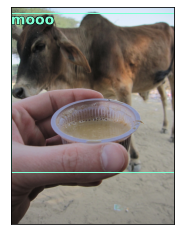

In [ ]:
ax = show_im(im)
draw_rect(ax, [*bbox[0],*bbox[1]])
draw_text(ax, bbox[0], 'mooo')

### `BBox` and `ImageBBox` classes with `show()` methods

In [ ]:
class BBox(fastuple):
    def show(self, ax=None, **kwargs):
        p1, p2 = self
        if not ax: print("No axes")
        return draw_rect(ax, [*p1, *p2], **kwargs)

In [ ]:
class ImageBBox(fastuple):
    def show(self, ax=None, **kwargs):
        im, bbox = self
        ax = show_im(im)
        return bbox.show(ax=ax, **kwargs)

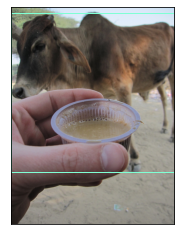

In [ ]:
bbox = BBox(bbox)
imbb = ImageBBox(im, bbox)
imbb.show()

# Old DataBlock method

In [ ]:
def label_func(p): return path2bbox[p]

In [ ]:
db = DataBlock(
    blocks=(ImageBlock, PointBlock),
    splitter=ColSplitter(),
    get_x=ColReader('im'),
    get_y=ColReader('bbox'),
    item_tfms=[PointScaler(), Resize(224, ResizeMethod.Squish), ToTensor()],
    batch_tfms=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)],
    n_inp=1
)
dls = db.dataloaders(df)
xb,yb = dls.one_batch()
print(xb.shape, yb.shape)
# ib,bb,lb = dls.one_batch()
# print(ib.shape, bb.shape, lb.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64, 2, 2])


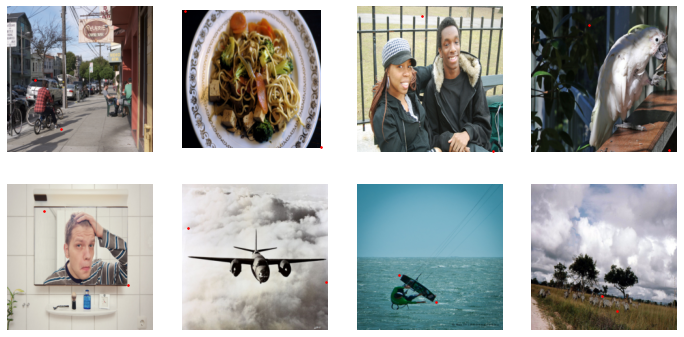

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

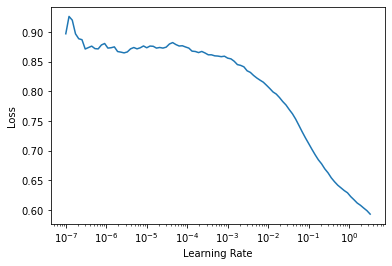

In [ ]:
learner = cnn_learner(dls, resnet18, y_range=(-1,1), batch_size=64)
lr_min,lr_steep = learner.lr_find()

In [ ]:
lr_min, lr_steep

(0.33113112449646, 0.0831763744354248)

In [ ]:
learner.fine_tune(3, lr=slice(.03,.5)) 

epoch,train_loss,valid_loss,time
0,0.396237,0.178944,00:14


epoch,train_loss,valid_loss,time
0,0.200525,0.138656,00:16
1,0.135152,0.110196,00:16
2,0.109149,0.105884,00:17


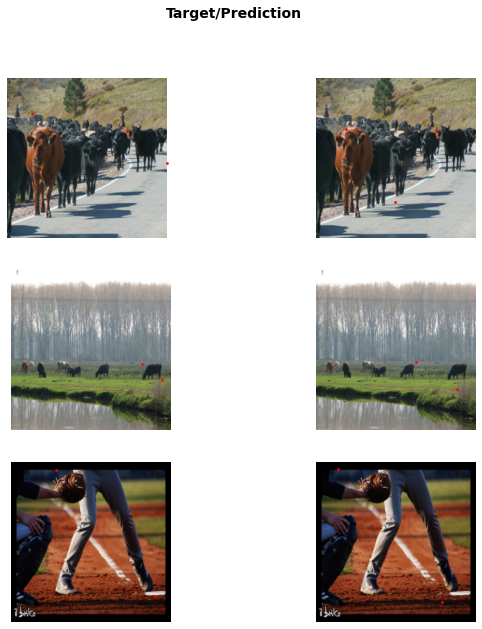

In [ ]:
learner.show_results(nrows=3,ncols=1, figsize=(10,10)) 